<a href="https://colab.research.google.com/github/dafeRoy/pytorch_projects/blob/main/randomly_or_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("Book1.xlsx")

In [3]:
df

,Name of Institution,Ombudsman Agent Name,Product
0,Barclays Bank Plc,Simon Hollingshead,Card
1,Nationwide Building Society,Rebecca Connelley,Mortgage
2,FirstRand Bank Limited,Rebecca Connelley,Hire purchase
3,Barclays Bank Plc,Gemma Farrell,Card
4,MBNA Limited,Sonia Hussain,Card
...,...,...,...
36172,Tesco Personal Finance PLC,Katrina Hyde,Card
36173,Capital One (Europe) plc,Amy Osborne,Card
36174,The Royal Bank of Scotland Plc,Katrina Hyde,Card
36175,Leeds Building Society,Emma Ali-Noor,Mortgage


In [4]:
agent_specialization = df.groupby("Ombudsman Agent Name").agg({
    "Name of Institution": pd.Series.nunique,
    "Product": pd.Series.nunique,
    "Ombudsman Agent Name": "count"
}).rename(columns={"Ombudsman Agent Name": "Case_Count", "Name of Institution": "Unique_Institutions", "Product": "Unique_Products"})

print(agent_specialization.sort_values(by="Case_Count", ascending=False))


                      Unique_Institutions  Unique_Products  Case_Count
Ombudsman Agent Name                                                  
Mark Richardson                        95               11        1064
Susan Webb                             44                7         936
Steve Thomas                          102               10         891
Roxy Boyce                            145                7         765
Michael Campbell                       86                8         675
...                                   ...              ...         ...
Brad Mcilquham                          1                1           1
Stephen Dickie                          1                1           1
Siobhan Mcbride                         1                1           1
ouglas Sayers                           1                1           1
Úna Mckevitt                            1                1           1

[294 rows x 3 columns]


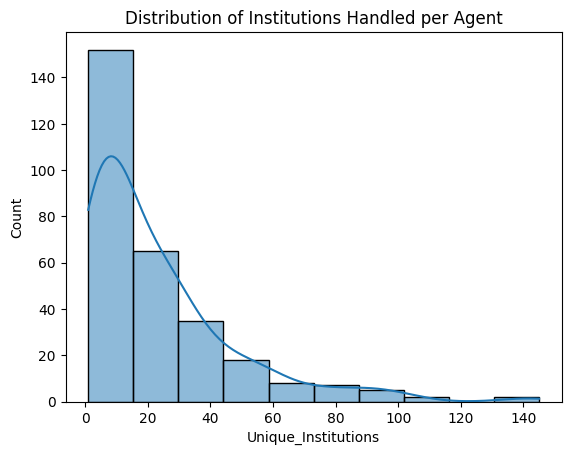

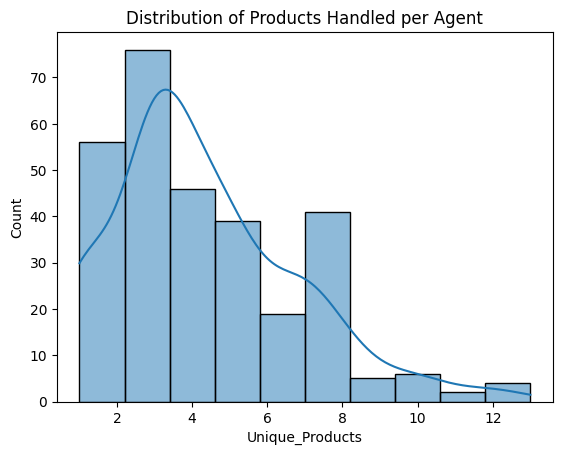

In [5]:
sns.histplot(agent_specialization["Unique_Institutions"], bins=10, kde=True)
plt.title("Distribution of Institutions Handled per Agent")
plt.show()

sns.histplot(agent_specialization["Unique_Products"], bins=10, kde=True)
plt.title("Distribution of Products Handled per Agent")
plt.show()

In [6]:
from scipy.stats import chi2_contingency

# Cross-tab between agents and institutions
agent_institution_ct = pd.crosstab(df["Ombudsman Agent Name"], df["Name of Institution"])
chi2_inst, p_inst, *_ = chi2_contingency(agent_institution_ct)

# Cross-tab between agents and products
agent_product_ct = pd.crosstab(df["Ombudsman Agent Name"], df["Product"])
chi2_prod, p_prod, *_ = chi2_contingency(agent_product_ct)

print(f"Agent-Institution Dependency p-value: {p_inst}")
print(f"Agent-Product Dependency p-value: {p_prod}")

Agent-Institution Dependency p-value: 0.0
Agent-Product Dependency p-value: 0.0


In [ ]:
# If p_inst < 0.05: suggests agents are not randomly assigned to institutions.
# If p_prod < 0.05: suggests agents are not randomly assigned to products.

In [ ]:
"""
Entropy Analysis:
Low entropy means the agent mostly handles one institution/product → specialization.
High entropy means the agent handles a wide variety → generalist.
"""

In [7]:
from scipy.stats import entropy

# Entropy for each agent's distribution over institutions
agent_inst_entropy = df.groupby('Ombudsman Agent Name')['Name of Institution'].apply(lambda x: entropy(x.value_counts(normalize=True)))
agent_prod_entropy = df.groupby('Ombudsman Agent Name')['Product'].apply(lambda x: entropy(x.value_counts(normalize=True)))

print(agent_inst_entropy.sort_values())  # Low values → specialization
print(agent_prod_entropy.sort_values())


Ombudsman Agent Name
Úna Mckevitt           0.000000
Carole Auchterlonie    0.000000
Boothroyd              0.000000
Brad Mcilquham         0.000000
Sue Wrigley            0.000000
                         ...   
Kristina Mathews       3.702966
Paul Bishop            3.804789
Roxy Boyce             3.837743
Sharon Kerrison        3.867833
Jan Ferrari            4.173388
Name: Name of Institution, Length: 294, dtype: float64
Ombudsman Agent Name
Boothroyd              0.000000
Carole Auchterlonie    0.000000
Brad Mcilquham         0.000000
Steve Wise             0.000000
Susan Peter            0.000000
                         ...   
Barbara Wight          1.585934
David Johnson          1.640046
Clair Bantin           1.643860
Julian Cridge          1.829838
Paul Bishop            1.856615
Name: Product, Length: 294, dtype: float64


In [ ]:
"""
Clustering Agents by Activity:
If clusters form clearly, it suggests agents are assigned based on product patterns (i.e., non-random)
"""

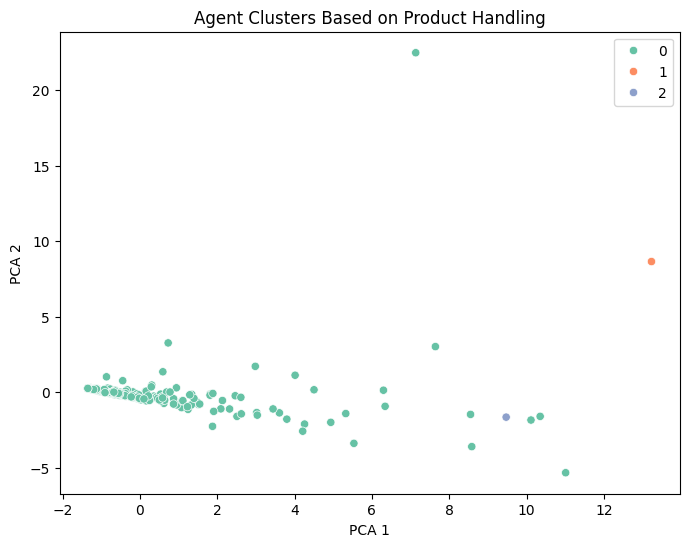

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Create a pivot table: Agent x Product counts
agent_product_matrix = pd.crosstab(df['Ombudsman Agent Name'], df['Product'])

# Normalize
X = StandardScaler().fit_transform(agent_product_matrix)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Cluster
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Visualize
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set2')
plt.title("Agent Clusters Based on Product Handling")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [ ]:
"""
Predictive Modeling:
High accuracy (e.g. > 0.5 with many classes) implies non-random, rule-based allocation.
"""

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode features
df_enc = df.copy()
le_agent = LabelEncoder()
le_inst = LabelEncoder()
le_prod = LabelEncoder()

df_enc['Agent_encoded'] = le_agent.fit_transform(df['Ombudsman Agent Name'])
df_enc['Institution_encoded'] = le_inst.fit_transform(df['Name of Institution'])
df_enc['Product_encoded'] = le_prod.fit_transform(df['Product'])

# Predict agent using institution and product
X = df_enc[['Institution_encoded', 'Product_encoded']]
y = df_enc['Agent_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print(f"Predictive accuracy of agent from institution/product: {score:.2f}")


Predictive accuracy of agent from institution/product: 0.06


In [ ]:
"""
Heatmaps / Cross-tab Visualization:
Visually shows whether agents handle a narrow or broad range.
"""

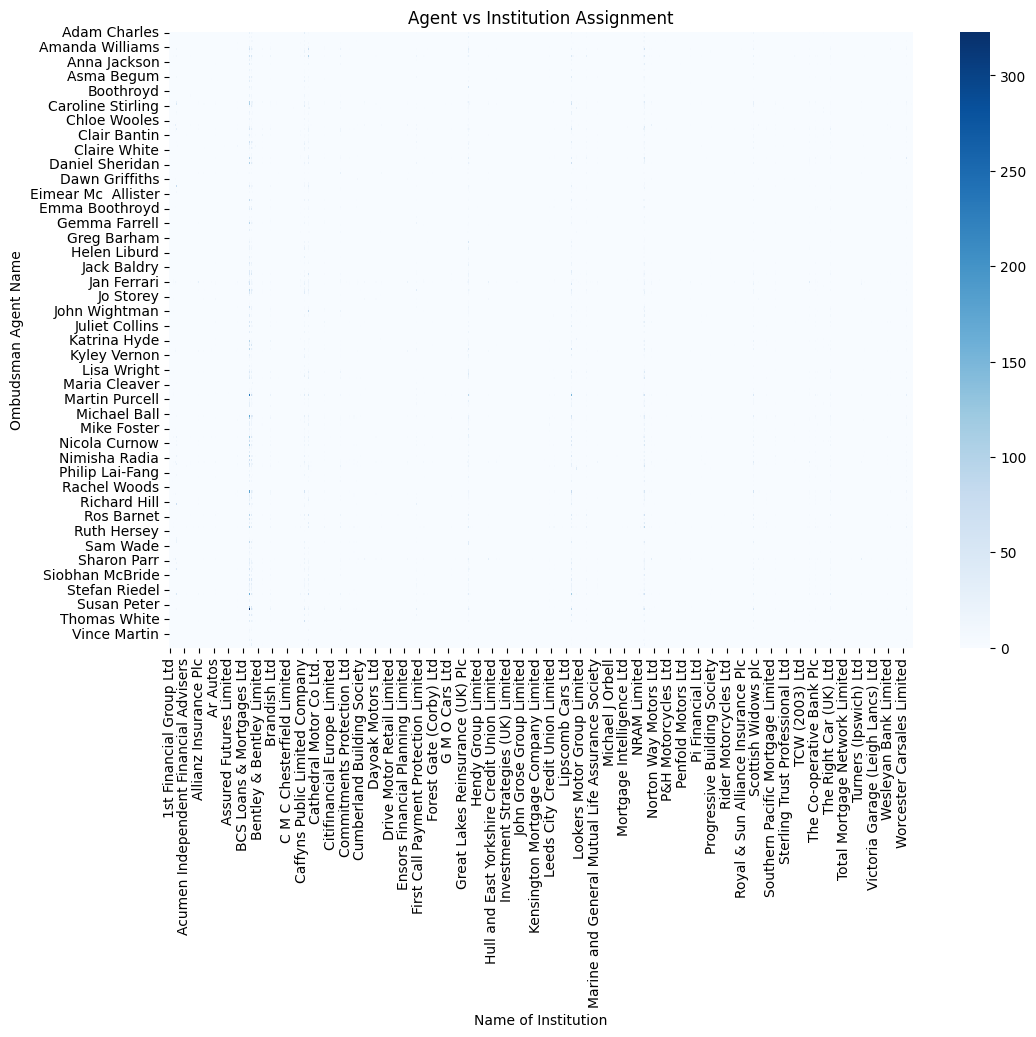

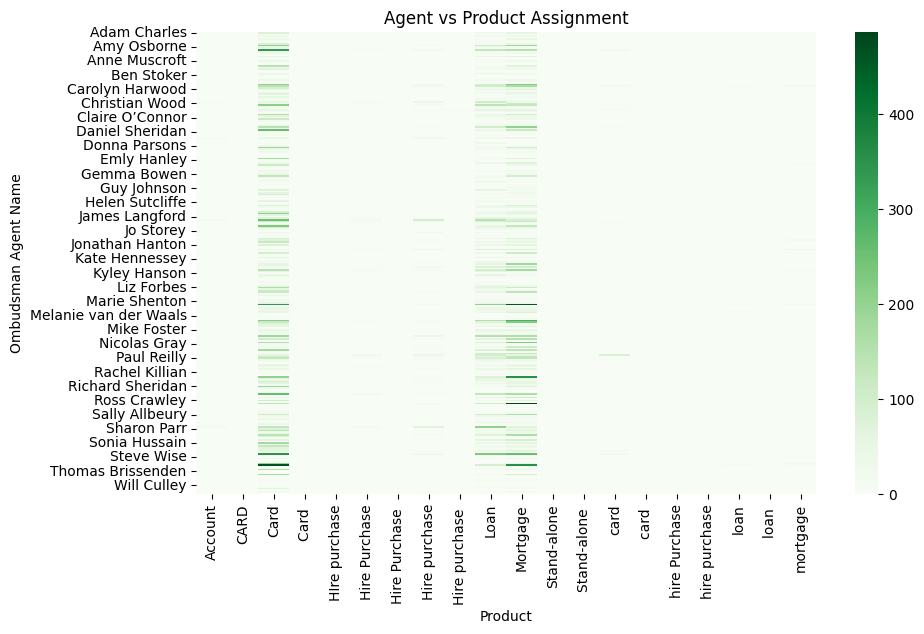

In [10]:
import seaborn as sns

# Heatmap of Agent vs Institution
inst_matrix = pd.crosstab(df['Ombudsman Agent Name'], df['Name of Institution'])
plt.figure(figsize=(12,8))
sns.heatmap(inst_matrix, cmap='Blues', cbar=True)
plt.title("Agent vs Institution Assignment")
plt.show()

# Heatmap of Agent vs Product
prod_matrix = pd.crosstab(df['Ombudsman Agent Name'], df['Product'])
plt.figure(figsize=(10,6))
sns.heatmap(prod_matrix, cmap='Greens', cbar=True)
plt.title("Agent vs Product Assignment")
plt.show()
